# Model training all folds d30_s30_vpos

In [1]:
import os
import pickle
import gc

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

from utils import get_cuda
from data_proc import read_data, remove_death, build_vocab
from dataset_func import build_dataset, BuildDataset, get_dataloader, read_pickled_ds
from transformer_model import TransformerCNNModel
from model_func import training_process, epoch_val, epoch_train

### Input

In [2]:
# Filepaths
num_folds = 5

main_dir = "../../../data/readmission/"
train_dirs = [os.path.join(main_dir, f"fold_{idx}/train/") for idx in range(num_folds)]
test_dirs = [os.path.join(main_dir, f"fold_{idx}/test/") for idx in range(num_folds)]
vocab_dirs = [os.path.join(main_dir, f"fold_{idx}/vocab/") for idx in range(num_folds)]

train_dl_fps = [os.path.join(train_dir, "train_datalist_d30_s30_vall_mf10.pkl") for train_dir in train_dirs]
test_dl_fps = [os.path.join(test_dir, "test_datalist_d30_s30_vall_mf10.pkl") for test_dir in test_dirs]
vocab_fps = [os.path.join(vocab_dir, f"vocab_d30_s30_vall_mf10") for vocab_dir in vocab_dirs]

#model_dir = "./models_d30_s30_vpos/"
# Options
x_lst = [str(x) for x in range(365, -1, -1)]
n_days = 30
seq_per_day = 30
y_target = "unplanned_readmission"
uid = "discharge_id"
batch_size=512

### Read in data and create data loader: single fold

In [3]:
emsize = 8 # embedding dimension
nhid = 32 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.3 # the dropout value
n_class = 2

In [4]:
train_metric = {}
for fold, (train_fp, test_fp, vocab_fp) in enumerate(
    zip(train_dl_fps, test_dl_fps, vocab_fps)
):
    print("\n" + "*" * 30 + "Fold {}".format(fold) + "*" * 50)
    print(
        f"Processing \n \
        \t train: {train_fp} \n \
        \t test: {test_fp} \n \
        \t vocab: {vocab_fp} \n"
    )

    whole_ids, whole_data, whole_labels, whole_mask = read_pickled_ds(
        file_dir=train_fp, seq_length=n_days, event_length=seq_per_day
    )
        
    train_dataset = BuildDataset(
        data_list=[whole_ids, whole_data, whole_labels, whole_mask]
    )
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
    )

    whole_ids, whole_data, whole_labels, whole_mask = read_pickled_ds(
        file_dir=test_fp, seq_length=n_days, event_length=seq_per_day
    )
    test_dataset = BuildDataset(
        data_list=[whole_ids, whole_data, whole_labels, whole_mask]
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )
    
    vocab = torch.load(vocab_fp)
    ntokens = len(vocab.stoi)
    print(f"Nb tokens: {ntokens}")
    
    model = TransformerCNNModel(
        ntokens,
        emsize,
        nhead,
        nhid,
        nlayers,
        n_class,
        device="gpu",
        seq_length=30,
        num_events=30,
        dropout=dropout,
    )

    train_metric["fold_" + str(fold)] = training_process(
        model=model,
        epoch=10,
        dataloaders={"train": train_dataloader, "val": test_dataloader},
        save_model=None,
        test=False,
    )


******************************Fold 0**************************************************
Processing 
         	 train: ../../../data/readmission/fold_0/train/train_datalist_d30_s30_vall_mf10.pkl 
         	 test: ../../../data/readmission/fold_0/test/test_datalist_d30_s30_vall_mf10.pkl 
         	 vocab: ../../../data/readmission/fold_0/vocab/vocab_d30_s30_vall_mf10 

Nb tokens: 18884
parameters: embsize:8, nhead:2, nhid:32, nlayers:1, dropout:0.3
available device: cuda
number of GPUS available: 4
device: gpu
----------Epoch 1/10------------------------------
epoch_train_loss: 0.4069805114290718 epoch train AUC: 0.6380930101973581
epoch_val_loss: 0.4121447621849282 epoch val AUC: 0.6618533972179024
----------Epoch 2/10------------------------------
epoch_train_loss: 0.4005562325912099 epoch train AUC: 0.6634609694250609
epoch_val_loss: 0.40439099124625155 epoch val AUC: 0.6647082899261963
----------Epoch 3/10------------------------------
epoch_train_loss: 0.39837967159314946 epoch trai

epoch_train_loss: 0.3989371288866536 epoch train AUC: 0.6695422953338687
epoch_val_loss: 0.40948037278827787 epoch val AUC: 0.6669903362700191
----------Epoch 4/10------------------------------
epoch_train_loss: 0.39771000445864596 epoch train AUC: 0.6735222326934888
epoch_val_loss: 0.4047661221017619 epoch val AUC: 0.666618725987264
----------Epoch 5/10------------------------------
epoch_train_loss: 0.396612401216393 epoch train AUC: 0.6769776584789587
epoch_val_loss: 0.40962326370557667 epoch val AUC: 0.6668841116686312
----------Epoch 6/10------------------------------
epoch_train_loss: 0.3956902474043022 epoch train AUC: 0.679852374094463
epoch_val_loss: 0.4042026056205387 epoch val AUC: 0.66587407211997
----------Epoch 7/10------------------------------
epoch_train_loss: 0.39510358456650263 epoch train AUC: 0.6815751405449755
epoch_val_loss: 0.4071703726355651 epoch val AUC: 0.6660142224300359
----------Epoch 8/10------------------------------
epoch_train_loss: 0.3943015488562724

In [5]:
overall_auc = []
print("individual fold results")
for idx in range(num_folds):
    print(f"fold_{idx}: {max(train_metric[f'fold_{idx}']['val_metric'])}")
    overall_auc.append(max(train_metric[f'fold_{idx}']['val_metric']))
          
print('Average AUC: {}'.format(np.round(np.mean(overall_auc), 3)))
print('Std AUC: {}'.format(np.round(np.std(overall_auc), 3)))

individual fold results
fold_0: 0.6647082899261963
fold_1: 0.668510042886064
fold_2: 0.666091840868092
fold_3: 0.6669903362700191
fold_4: 0.6663691216918648
Average AUC: 0.667
Std AUC: 0.001


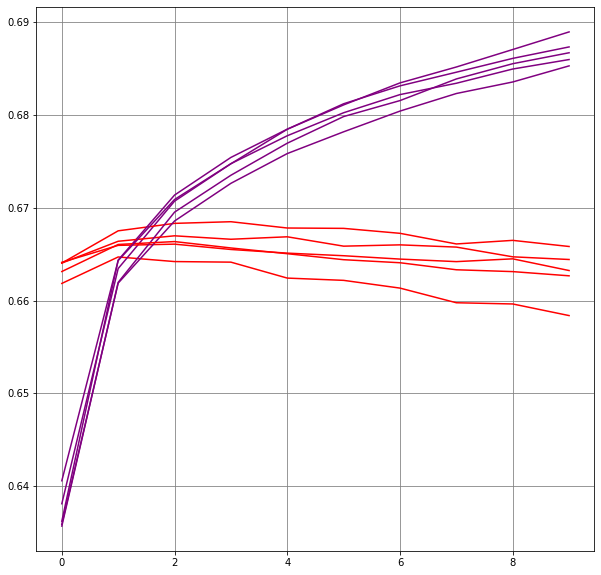

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for idx in range(num_folds):
    plt.plot(train_metric[f'fold_{idx}']['val_metric'], color='red')
    plt.plot(train_metric[f'fold_{idx}']['train_metric'], color='purple')
    
plt.grid(color='gray')
